# Experiment 6: BC for data

In this experiment we will add the wind and boundary conditions to the data.

### Imports

In [1]:
# Import packages:
import mikeio
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import os
import sys
import pandas as pd 
import seaborn as sns
import pickle as pkl


sys.path.append("../")
plt.style.use("seaborn-v0_8-whitegrid")

from Scripts import my_functions as mf

from mikeio.eum import EUMUnit
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from IPython.display import HTML
from tqdm import tqdm

### Setup

In [2]:
## Find the relative path to Data/DHI_wk_sim/Area.dfsu from current directory:

# Go up two levels from current directory:
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))

# Define path to dfsu file:
path_area = os.path.join(path, "Data/DHI_yr_sim/Area.dfsu")

path_wind = os.path.join(path, "Data/DHI_yr_sim/HD_OERESUND_CREA6_1997_v2.m21fm - Result Files/wind.dfs0")

# Define paths to boundary conditions:
path_bc_north = os.path.join(path, "Data/DUMP/waterlevel_bc/waterlevel_north.dfs1")
path_bc_south = os.path.join(path, "Data/DUMP/waterlevel_bc/waterlevel_south.dfs1")

# Open dfsu file:
mikeio.open(path_area)

Dfsu2D
number of elements: 17980
number of nodes: 10460
projection: LONG/LAT
items:
  0:  Surface elevation <Surface Elevation> (meter)
  1:  Total water depth <Water Depth> (meter)
  2:  U velocity <u velocity component> (meter per sec)
  3:  V velocity <v velocity component> (meter per sec)
time: 18191 steps with dt=1800.0s
      1996-12-18 00:00:00 -- 1997-12-31 23:00:00

In [3]:
# Get first and last time step:
area_time = mikeio.open(path_area).time
print("First observation:  ", area_time[0], "\n", 
      "Last observation:  ", area_time[-1])

First observation:   1996-12-18 00:00:00 
 Last observation:   1997-12-31 23:00:00


In [4]:
# Access boundary data timestamps:
bc_time = mikeio.open(path_bc_north).time

In [5]:
# Access wind data timestamps:
wind_time = mikeio.open(path_wind).time

In [6]:
# Find time index:
fit_id_start, fit_id_stop = \
    area_time.get_indexer(["1997-01-01", "1997-02-01"])

area_time[fit_id_start:fit_id_stop]

DatetimeIndex(['1997-01-01 00:00:00', '1997-01-01 00:30:00',
               '1997-01-01 01:00:00', '1997-01-01 01:30:00',
               '1997-01-01 02:00:00', '1997-01-01 02:30:00',
               '1997-01-01 03:00:00', '1997-01-01 03:30:00',
               '1997-01-01 04:00:00', '1997-01-01 04:30:00',
               ...
               '1997-01-31 19:00:00', '1997-01-31 19:30:00',
               '1997-01-31 20:00:00', '1997-01-31 20:30:00',
               '1997-01-31 21:00:00', '1997-01-31 21:30:00',
               '1997-01-31 22:00:00', '1997-01-31 22:30:00',
               '1997-01-31 23:00:00', '1997-01-31 23:30:00'],
              dtype='datetime64[ns]', length=1488, freq=None)

In [7]:
# Choose sample size: (2 weeks)
n_samples = 48*7*2

# 2-week-sized systematic sample:
sample_ids = np.linspace(fit_id_start, fit_id_stop, n_samples, dtype=int)

## Load data:

In [8]:
data_area_fit = mikeio.read(path_area,
                            items=[0,2,3],
                            time=area_time[fit_id_start:fit_id_stop]
                            )

data_bc_north_fit = mikeio.read(path_bc_north,
                                items=[0],
                                time=area_time[fit_id_start:fit_id_stop],
                                )

data_bc_south_fit = mikeio.read(path_bc_south,
                                items=[0],
                                time=area_time[fit_id_start:fit_id_stop]
                                )

data_wind_fit = mikeio.read(path_wind,
                            items=range(50),
                            time=area_time[fit_id_start:fit_id_stop],
                            )


In [9]:
print("\n", data_area_fit)
print("\n", data_bc_north_fit)
print("\n", data_bc_south_fit)
print("\n", data_wind_fit)


 <mikeio.Dataset>
dims: (time:1488, element:17980)
time: 1997-01-01 00:00:00 - 1997-01-31 23:30:00 (1488 records)
geometry: Dfsu2D (17980 elements, 10460 nodes)
items:
  0:  Surface elevation <Surface Elevation> (meter)
  1:  U velocity <u velocity component> (meter per sec)
  2:  V velocity <v velocity component> (meter per sec)

 <mikeio.Dataset>
dims: (time:1488, x:7)
time: 1997-01-01 00:00:00 - 1997-01-31 23:30:00 (1488 records)
geometry: Grid1D (n=7, dx=1000)
items:
  0:  North <Water Level> (meter)

 <mikeio.Dataset>
dims: (time:1488, x:7)
time: 1997-01-01 00:00:00 - 1997-01-31 23:30:00 (1488 records)
geometry: Grid1D (n=7, dx=1600)
items:
  0:  South <Water Level> (meter)

 <mikeio.Dataset>
dims: (time:1488)
time: 1997-01-01 00:00:00 - 1997-01-31 23:30:00 (1488 records)
geometry: GeometryUndefined()
number of items: 50


### Visualize wind direction and magnitudes

In [10]:
# Allocate lists:
x, y, u, v = [], [], [], []

# Wind components:
for i in range(0, 25):
    
    # Extract coordinates from item names:
    coord_str = data_wind_fit.items[i].name[5:16]
    x_tmp, y_tmp = coord_str.split("-")

    # Append data:
    x.append(float(x_tmp))
    y.append(float(y_tmp))
    u.append(data_wind_fit[i].values[0])
    v.append(data_wind_fit[i+25].values[0])

# Create dataframe:
wind_df = pd.DataFrame({"x": x, "y": y, "u": u, "v": v})

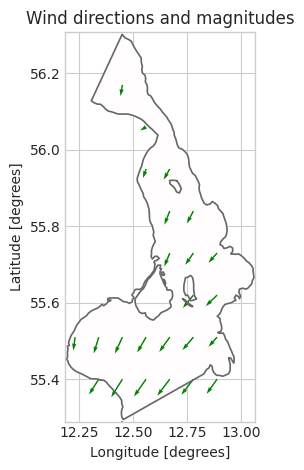

In [11]:
# Create plotting object:
wind_plot_obj = data_area_fit.U_velocity[0].copy()
wind_plot_obj.values *= 0

# Plot wind direction:
fig1, ax = plt.subplots()
wind_plot_obj.plot(ax=ax, cmap="seismic",
                     add_colorbar=False)

ax.quiver(wind_df.x, wind_df.y, wind_df.u, wind_df.v, color="green", scale=50)

plt.title("Wind directions and magnitudes")
fig1.tight_layout()
plt.show()

In [12]:
fig1.savefig("../Figures/Exp_6_wind_directions.png", dpi=100)

## Combine everything:
Create state vector with water surface elevations and velocities components, north and south boundary conditions and wind velocity components

In [13]:
# Access wind velocity data:
wind_fit_u_values = [data_wind_fit[i].values for i in range(0, 25)]
wind_fit_v_values = [data_wind_fit[i].values for i in range(25, 50)]

# Reshape data:
wind_fit_u_values = \
    np.concatenate(
        [wind_fit_u_values[i].reshape(-1, 1) for i in range(0, 25)],
        axis=1
    )

wind_fit_v_values = \
    np.concatenate(
        [wind_fit_v_values[i].reshape(-1, 1) for i in range(0, 25)],
        axis=1
    )


In [14]:
# Concatenate data:
fit_values = np.concatenate([data_area_fit[0].values,
                             data_area_fit[1].values,
                             data_area_fit[2].values,
                             data_bc_north_fit[0].values,
                             data_bc_south_fit[0].values,
                             wind_fit_u_values,
                             wind_fit_v_values],
                             axis=1)

In [22]:
data_bc_north_fit[0]

(1488, 7)

In [15]:
# Create scaler and IPCA object:
scaler = StandardScaler()
pca = mf.myModels.IPCA(n_components=100)

# Scale data:
fit_values_scaled = scaler.fit_transform(fit_values)

# Fit IPCA:
pca.fit(fit_values_scaled)

/home/emsla/.local/lib/python3.10/site-packages/sklearn/decomposition/_incremental_pca.py:348: RuntimeWarning: Mean of empty slice.
  self.noise_variance_ = explained_variance[self.n_components_ :].mean()
/home/emsla/.local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [17]:
# Save scaler and pca (in Coding/Data_Results):
if 1:
    with open("../Data_Results/Exp_6_scaler.pkl", "wb") as f:
        pkl.dump(scaler, f)

    with open("../Data_Results/Exp_6_pca.pkl", "wb") as f:
        pkl.dump(pca, f)  

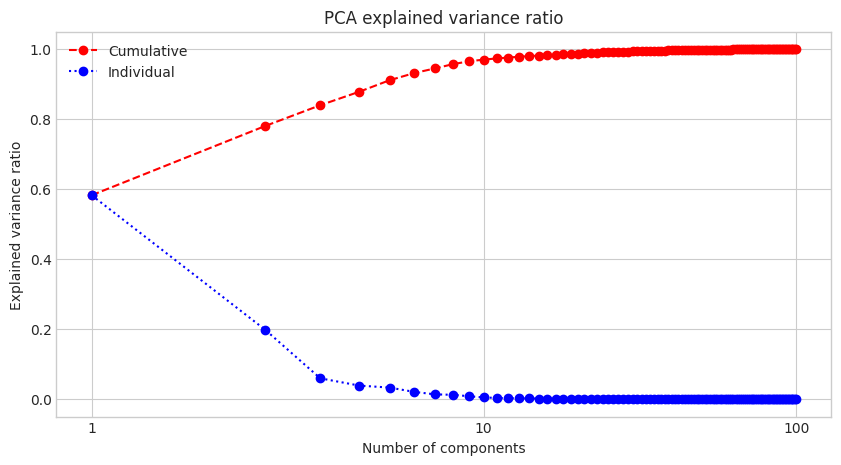

In [18]:
# Plot the PCA E.V.R:
fig2 = plt.figure(figsize=(10,5))
pca_x_ticks = np.arange(1, pca.model.n_components_+1, 1)
plt.plot(pca_x_ticks,
         np.cumsum(pca.model.explained_variance_ratio_),
         "o",
         linestyle="dashed",
         color="red")

plt.plot(pca_x_ticks,
         pca.model.explained_variance_ratio_,
         "o",
         linestyle="dotted",
         color="blue")

plt.legend(["Cumulative", "Individual"])
plt.xscale("symlog")

plt.xlabel("Number of components")
plt.ylabel("Explained variance ratio")

plt.xticks(10**np.arange(3),
           [str(10**i) for i in np.arange(3)])

plt.title("PCA explained variance ratio")
plt.show()

In [20]:
(pca.model.explained_variance_ratio_).sum()

0.9992899217292857